# Cluster job tutorial

**Goal:** example of how to use the `Selene_Job` class to send a job to the cluster directly from the local notebook.
  
This notebook is divided in two parts:
* **1. A classic machine learning task example**
* **2. How to send it on the cluster**
* **3. More computationally expensive example**

In [1]:
%matplotlib inline
%run setup_environment.py
%run ml_tools.py
%run custom_tools.py
%run Selene_Job.ipy

current_conda_env = !echo $CONDA_DEFAULT_ENV
check_conda_env(current_conda_env[0])

Setup environment... done!


✅ <span style='color:green'>Working on **impact-annotator_env** conda environment.</span>

## A classic machine learning task example

In [2]:
# get raw data
impact = pd.read_csv('../../data/annotated_final_IMPACT_mutations_180508.txt', sep = '\t', low_memory = False)

# shuffle data
rng = np.random.RandomState(0)
permutation = rng.permutation(len(impact))
impact = impact.iloc[permutation]

# create the is_somatic class
impact['is_somatic'] = impact.confidence_class != "UNLIKELY"
label_feature_name = 'is_somatic'

# select data
impact_selected = pd.concat([impact[~impact.is_somatic],
                             impact[impact.is_somatic].iloc[0:20000]], ignore_index = True)
    
# choose features
feature_names = ['t_depth', 't_vaf', 't_alt_count', 'n_depth', 'n_vaf', 'n_alt_count', 'sample_coverage', 'frequency_in_normals',
                 'VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_COSMIC_CNT', 'VEP_gnomAD_AF', 'VEP_in_dbSNP',
                 'VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN',
                 'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH', 'VEP_gnomAD_total_AF_max', 'VEP_gnomAD_total_AF', 'Kaviar_AF',
                 'gene_type', label_feature_name]
impact_selected = impact_selected[feature_names].dropna()
    
# transform categorical features
categorical_features_names = [ 'VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_in_dbSNP', 'gene_type']
impact_selected = pd.get_dummies(impact_selected, columns = categorical_features_names, sparse = True)

# create features matrix and target array
X = impact_selected.drop(label_feature_name, axis = 1)
y = impact_selected[label_feature_name]

In [35]:
# choose a cross-validation strategy
from sklearn.model_selection import StratifiedShuffleSplit
cv_strategy = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 1)

# choose a model
from sklearn.naive_bayes import GaussianNB
model_GaussianNB = GaussianNB()

# run the model
metrics = run_model(model_GaussianNB, X, y, cv_strategy)

Run model
  - fold 1/5... done! (0.08s)
  - fold 2/5... done! (0.08s)
  - fold 3/5... done! (0.07s)
  - fold 4/5... done! (0.07s)
  - fold 5/5... done! (0.07s)


In [37]:
print_fold_metrics(metrics)
print_mean_metrics(metrics)

Fold #: [fit_time | score_time]
   - accuracy: [test_accuracy | train_accuracy]
   - ROC AUC : [test_roc_auc  | train_roc_auc]

Fold 1: [0.05s | 0.03s]
  - accuracy: [0.80 | 0.80]
  - ROC AUC : [0.79 | 0.80]
Fold 2: [0.05s | 0.03s]
  - accuracy: [0.80 | 0.80]
  - ROC AUC : [0.81 | 0.80]
Fold 3: [0.05s | 0.03s]
  - accuracy: [0.80 | 0.79]
  - ROC AUC : [0.80 | 0.80]
Fold 4: [0.05s | 0.03s]
  - accuracy: [0.80 | 0.80]
  - ROC AUC : [0.79 | 0.80]
Fold 5: [0.05s | 0.03s]
  - accuracy: [0.81 | 0.80]
  - ROC AUC : [0.81 | 0.80]
- Mean accuracy: 0.80 ± 0.01
- Mean ROC AUC : 0.80 ± 0.02


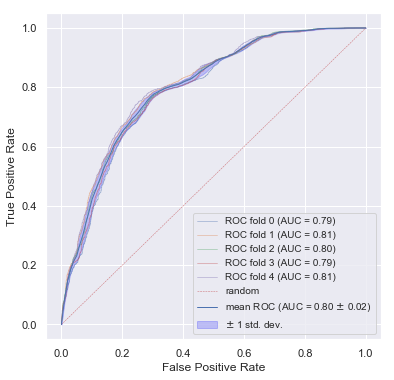

In [7]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
plot_roc(metrics, ax)

## How to send it on the cluster

### Create a job

We create a job, identified by its job id `cluster_tutorial_Gaussian_NB`, and by providing the user cluster username. This creates a directory on the local computer, in the project `ssh_remote_jobs/` folder, named `job_cluster_tutorial_Gaussian_NB`.

In [8]:
job = Selene_Job('cluster_tutorial_Gaussian_NB', 'guilminp')

➞ mkdir on local computer ssh_remote_jobs/job_cluster_tutorial_Gaussian_NB


<span style='color:green'>Job < cluster_tutorial_Gaussian_NB >: </span>✅ created<br>

You can also decide to load a previously created job, for example if we would like to find back the previous job:

In [9]:
job_same = Selene_Job('cluster_tutorial_Gaussian_NB', 'guilminp', load_from_id = True)

<span style='color:green'>Job < cluster_tutorial_Gaussian_NB >: </span>✅ job found and reloaded<br>

### Load the data used by the job

The following saves `X` and `y` objects as pickle objects in the job directory (`ssh_remote_jobs/job_cluster_tutorial_Gaussian_NB`). This allows to separate the creation of the dataset (feature selection, formatting, etc...) from the run of the machine learning algorithm.

In [10]:
job.load_data(X, y)

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_cluster_tutorial_Gaussian_NB


<span style='color:green'>Job < cluster_tutorial_Gaussian_NB >: </span>✅ data loaded<br>

### Write the job python script

Here we write the python script that will be run in the cluster, it is stored in the `script.py` file in the local `ssh_remote_jobs/job_cluster_tutorial_Gaussian_NB` folder:

In [22]:
%%writefile {job.local_job_directory_path}/script.py

# load the ml_tools functions
print("Setup environment...", end = "")
import sys
sys.path.append("../../")

from ml_tools import *
print(" done!")


print("Run model...")
# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# choose a cross-validation strategy
from sklearn.model_selection import StratifiedShuffleSplit
cv_strategy = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 1)

# choose a model
from sklearn.naive_bayes import GaussianNB
model_GaussianNB = GaussianNB()

# run the model
metrics = run_model(model_GaussianNB, X, y, cv_strategy)
print(" done!")

print_fold_metrics(metrics)
print_mean_metrics(metrics_reduced)


print("Save metrics...", end = "")
metrics.to_pickle("metrics.pkl")
print(" done!")

Overwriting ssh_remote_jobs/job_cluster_tutorial_Gaussian_NB/script.py


### Run the job in the cluster

The following command copy the job directory on the cluster, setup the cluster environment and then bsub the job.

In [23]:
job.run()

➞ scp ssh_remote_jobs/job_cluster_tutorial_Gaussian_NB to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
script.py                                     100%  788   105.6KB/s   00:00    
X.pkl                                         100% 5266KB  13.5MB/s   00:00    
y.pkl                                         100%  452KB   9.2MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ launch job in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_cluster_tutorial_Gaussian_NB
Job <28140427> is submitted to default queue <sol>.


<span style='color:green'>Job < cluster_tutorial_Gaussian_NB >: </span>✅ submitted<br>

### Get the results of the job

If the job is not done yet we get this result:

In [24]:
job.get_results()

<span style='color:red'>Job < cluster_tutorial_Gaussian_NB >: </span>⚠️ does not exist, is not done yet or an error occured before the creation of `metrics.pkl`<br>

If it's done, we get this result:

In [25]:
job.get_results()

<span style='color:red'>Job < cluster_tutorial_Gaussian_NB >: </span>⚠️ does not exist, is not done yet or an error occured before the creation of `metrics.pkl`<br>

In [13]:
# print the metrics
job.metrics[['fit_time', 'score_time', 'train_accuracy', 'test_accuracy', 'train_roc_auc', 'test_roc_auc', 'best_parameters']]

,fit_time,score_time,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc,best_parameters
fold_number,,,,,,,
0,0.119426,0.06353,0.797739,0.799816,0.79922,0.788132,NaN
1,0.116823,1.75378,0.795119,0.795404,0.798381,0.806598,NaN
2,0.112872,0.0719275,0.793511,0.79761,0.79502,0.799848,NaN
3,0.113136,1.54435,0.796498,0.800735,0.796747,0.793025,NaN
4,0.11352,0.0727656,0.79875,0.807169,0.798306,0.80942,NaN


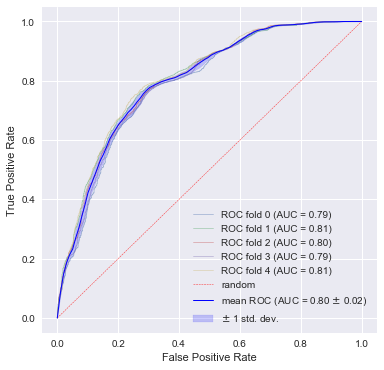

In [14]:
# plot the roc curve
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
plot_roc(cv_strategy.get_n_splits(), metrics, ax)

We can remove the job with the following command (it will delete the job directory in the cluster and on the local computer):

In [15]:
# job.remove()

## More computationally expensive example

In [16]:
job = Selene_Job('cluster_tutorial_GS_Random_Forest', 'guilminp')
job.load_data(X, y)

➞ mkdir on local computer ssh_remote_jobs/job_cluster_tutorial_GS_Random_Forest


<span style='color:green'>Job < cluster_tutorial_GS_Random_Forest >: </span>✅ created<br>

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_cluster_tutorial_GS_Random_Forest


<span style='color:green'>Job < cluster_tutorial_GS_Random_Forest >: </span>✅ data loaded<br>

In [17]:
%%writefile {job.local_job_directory_path}/script.py

# load the ml_tools functions
print("Setup environment...", end = "")
import sys
sys.path.append("../../")

from ml_tools import *
print(" done!")


print("Run model...")
# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# choose a cross-validation strategy
from sklearn.model_selection import StratifiedShuffleSplit
cv_strategy = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 1)

# choose an inner cross-validation strategy for the grid search
from sklearn.model_selection import GridSearchCV
inner_cv_strategy = StratifiedShuffleSplit(n_splits = 3, test_size = 0.2, random_state = 1)

# choose a model
from sklearn.ensemble import RandomForestClassifier
parameters_grid = [
    {'n_estimators': [10, 100, 1000], 'max_depth': [5, 20, 50]}
]
model_GS_RandomForestClassifier = GridSearchCV(RandomForestClassifier(), parameters_grid, cv = inner_cv_strategy, scoring = 'roc_auc', refit = True)

# run the model
metrics = run_model(model_GS_RandomForestClassifier, X, y, cv_strategy, grid_search = True, print_fold_metrics = True, print_grid_search_metrics = True)
print(" done!")


print("Save metrics...", end = "")
metrics.to_pickle("metrics.pkl")
print(" done!")

Writing ssh_remote_jobs/job_cluster_tutorial_GS_Random_Forest/script.py


In [18]:
job.run()

➞ scp ssh_remote_jobs/job_cluster_tutorial_GS_Random_Forest to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
X.pkl                                         100% 5266KB   8.6MB/s   00:00    
y.pkl                                         100%  452KB   9.3MB/s   00:00    
script.py                                     100% 1237   166.7KB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ launch job in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_cluster_tutorial_GS_Random_Forest
Job <28121688> is submitted to default queue <sol>.


<span style='color:green'>Job < cluster_tutorial_GS_Random_Forest >: </span>✅ submitted<br>

In [19]:
job.get_results()

<span style='color:red'>Job < cluster_tutorial_GS_Random_Forest >: </span>⚠️ does not exist, is not done yet or an error occured before the creation of `metrics.pkl`<br>

In [20]:
job.get_results()

<span style='color:green'>Job < cluster_tutorial_GS_Random_Forest >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_cluster_tutorial_GS_Random_Forest to ssh_remote_jobs/job_cluster_tutorial_GS_Random_Forest
metrics.pkl                                   100%  109KB   1.9MB/s   00:00    
job_output.txt                                100% 5166   275.1KB/s   00:00    
➞ load metrics.pkl in pandas dataframe self.metrics
➞ print main results
## Mean accuracy: 0.80 ± 0.01
## Mean ROC AUC : 0.80 ± 0.02


In [21]:
job.metrics[['fit_time', 'score_time', 'train_accuracy', 'test_accuracy', 'train_roc_auc', 'test_roc_auc', 'best_parameters']]

,fit_time,score_time,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc,best_parameters
fold_number,,,,,,,
0,463.99,8.69833,1,0.886029,1,0.894328,"{'max_depth': 50, 'n_estimators': 1000}"
1,430.654,5.91363,0.928857,0.879963,0.964691,0.902378,"{'max_depth': 20, 'n_estimators': 1000}"
2,439.959,6.12495,0.928397,0.879596,0.965676,0.891441,"{'max_depth': 20, 'n_estimators': 1000}"
3,449.694,8.45392,1,0.883824,1,0.893061,"{'max_depth': 50, 'n_estimators': 1000}"
4,434.36,5.75578,0.928076,0.886397,0.965417,0.89687,"{'max_depth': 20, 'n_estimators': 1000}"


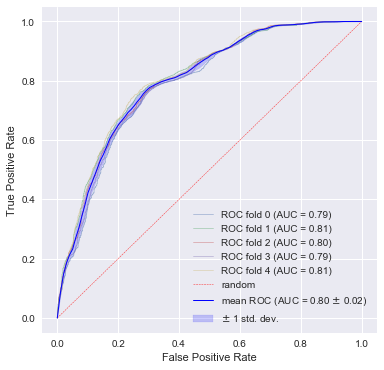

In [23]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
plot_roc(cv_strategy.get_n_splits(), metrics, ax)

In [30]:
# job.remove()

➞ rm on local computer ssh_remote_jobs/job_cluster_tutorial_GS_Random_Forest
➞ rm on cluster guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_cluster_tutorial_GS_Random_Forest


<span style='color:green'>Job < cluster_tutorial_GS_Random_Forest >: </span>✅ removed from local computer and cluster<br>